# Evaluate Models
* In this notebooks we'll implement the inference and post inference part of the pipeline. 
* Along with that we'll also try and implement functions to validate the predictions visually. 

## Imports

In [45]:
import pandas as pd
import numpy as np
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.datasets import mnist
import matplotlib.pyplot as plt
import matplotlib.patches as patches



## validate tensorflow 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Constants

In [46]:
data_dir = Path("..","data")
models_dir = Path("..","models")

## Import Scripts

In [47]:
import os
import sys
# Build an absolute path from this notebook's parent directory
module_path = os.path.abspath(os.path.join('..'))

# Add to sys.path if not already present
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src import graph_compatible_data_generator,object_detection_model
from src import training_utils as tu

## logic to auto reload scripts without restarting the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Test Data Pipeline

In [48]:
_, (x_test, y_test) = mnist.load_data()

X_tensor = tf.convert_to_tensor(x_test, dtype=tf.float32)
# X_tensor = tf.reshape(X_tensor, shape=(-1, 28, 28, 1))
y_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

batch_size = 32
raw_dataset = tf.data.Dataset.from_tensor_slices((X_tensor, y_tensor))

# create a generator for 2 digits
data_gen_2_digits = graph_compatible_data_generator.create_data_generator(2)
data_gen_3_digits = graph_compatible_data_generator.create_data_generator(3)
data_gen_4_digits = graph_compatible_data_generator.create_data_generator(4)
data_gen_5_digits = graph_compatible_data_generator.create_data_generator(5)

In [49]:
processed_test_dataset_2 = raw_dataset.map(
    data_gen_2_digits).map(lambda canvas,prediction: canvas).batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)

## Model Inference

### Load Model

In [50]:
# model_name = "experiment_0_digits_2_20_0.33.keras"
model_name = "experiment_1_digits_2_30_0.14.keras"

model = tf.keras.models.load_model(Path(models_dir, model_name), custom_objects={
                                   "calculate_model_loss": tu.calculate_model_loss, "objectness_metrics": tu.objectness_metrics, "bounding_box_metrics": tu.bounding_box_metrics, "classification_metrics": tu.classification_metrics, "ObjectDetectionModel": object_detection_model.ObjectDetectionModel})
model.summary()

Model: "object_detection_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_1 (Functional)       │ (32, 6, 6, 45)         │        21,845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,537 (256.01 KB)

 Trainable params: 21,845 (85.33 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 43,692 (170.68 KB)

### Prediction

In [51]:
# processed_test_dataset_2 = raw_dataset.map(
#     data_gen_2_digits).map(lambda canvas,prediction: canvas).batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)

# prediction = model.predict(processed_test_dataset_2)
# prediction.shape
## inspecting single prediction
# single_pred = prediction[:1,...]
# single_pred = tf.reshape(single_pred,shape=(-1,6,6,3, 15))
# tf.sigmoid(single_pred[0,0,0,0])


## Post Processing
* In this step, we are going to post process the predictions to select the best anchor boxes from all the predictions
* To do this we'll,
    * Reshape it to easily access the `15` features that the model predicts,
    * Apply `tf.sigmoid` to the objectness score of the boxes and discard any boxes that are below the threshold.
    * Decode the coordinates returned by remaining boxes and apply Non-Max Suppresion (NMS) algorithm on it. 
* 

In [52]:
def reshape_prediction(prediction_object):
    prediction_shape = tf.shape(prediction_object)
    batch_size = prediction_shape[0]
    grid_width = prediction_shape[1]
    grid_height = prediction_shape[2]
    reshaped_prediction = tf.reshape(prediction_object, shape=(batch_size,grid_width,grid_height,-1,15))
    return reshaped_prediction

### Map Sigmoid Function - Confidence Scores


In [53]:
def map_confidence_score(prediction_object):
    ## objectness is the first flag in last axis
    confidence_score = tf.sigmoid(prediction_object[...,0])    
    return confidence_score


### Post Process Predictions

In [54]:


@tf.function
def post_process(predictions, confidence_score_threshold=0.5, iou_threshold=0.5, max_boxes=5):

    @tf.function
    def _process_single_prediction_image(prediction_image):
        # tf.print("prediction_image shape : ", tf.shape(prediction_image))
        image_shape = tf.shape(prediction_image)
        grid_width = tf.cast(image_shape[0], dtype=tf.float32)
        grid_height = tf.cast(image_shape[1], dtype=tf.float32)

        # step 0: normalize image
        normalized_image = tf.sigmoid(prediction_image[..., :5])
        # print("normalized image shape : ", tf.shape(normalized_image))
        # step 1: calculate confidence score
        confidence_scores = normalized_image[..., 0]
        # tf.print("confidence_scores shape : ", tf.shape(confidence_scores))

        # step 2: create boolean mask based on confidence score
        confidence_score_mask = confidence_scores[...,
                                                  :] > confidence_score_threshold
        # tf.print("confidence_score_mask ", tf.shape(confidence_score_mask))

        # create coordinate grid to decode the grid coordinates
        gridx_coordinate_range = tf.range(grid_width, dtype=tf.float32)
        gridy_coordinate_range = tf.range(grid_height, dtype=tf.float32)

        grid_y, grid_x = tf.meshgrid(
            gridy_coordinate_range, gridx_coordinate_range, indexing="ij")
        image_grid = tf.stack(values=[grid_y, grid_x], axis=-1)
        image_grid = image_grid[:, :, tf.newaxis, :]

        # decode the coordinates
        # Get the offsets and apply sigmoid
        x_offset = normalized_image[..., 1]
        y_offset = normalized_image[..., 2]

        # Get the grid indices (notice the swapped 0 and 1!)
        grid_x_index = image_grid[..., 1]
        grid_y_index = image_grid[..., 0]

        # 3. Apply the correct formula
        decoded_x_norm = (grid_x_index + x_offset) / grid_width
        decoded_y_norm = (grid_y_index + y_offset) / grid_height

        width = normalized_image[..., 3]
        height = normalized_image[..., 4]

        decoded_box = tf.stack(
            [decoded_x_norm, decoded_y_norm, width, height], axis=-1)

        # decode class
        class_scores = tf.nn.softmax(prediction_image[..., 5:], axis=-1)

        # decoded prediction
        confidence_scores = confidence_scores[:, :, :, tf.newaxis]
        decoded_prediction = tf.concat(
            [confidence_scores, decoded_box, class_scores], axis=-1)

        # # step 3: filter boxes based on the mask
        filtered_boxes = tf.boolean_mask(
            decoded_prediction, confidence_score_mask)
        # tf.print("filtered_boxes : ", tf.shape(filtered_boxes))

        # step 4: filter scores based on the mask
        filtered_scores = filtered_boxes[:, 0]
        # tf.print("filtered_scores : ", tf.shape(filtered_scores))

        # step 5: read and decode the values for NMS algorithm
        # prediction object flag, x_center, y_center, width, height, one hot encoded class values (0 to 9)
        x_center = filtered_boxes[..., 1] * 100
        y_center = filtered_boxes[..., 2] * 100
        width = filtered_boxes[..., 3] * 100
        height = filtered_boxes[..., 4] * 100

        # calculate min and max values
        x_min = tf.floor(x_center - (width / 2))
        x_max = tf.floor(x_center + (width / 2))
        y_min = tf.floor(y_center - (height / 2))
        y_max = tf.floor(y_center + (height / 2))

        boxes = tf.stack([y_min, x_min, y_max, x_max], axis=1)
        # tf.print("boxes shape : ", tf.shape(boxes))

        # step 5: perform NMLS
        nms_indices = tf.image.non_max_suppression(
            boxes=boxes, scores=filtered_scores, max_output_size=max_boxes, iou_threshold=iou_threshold)
        # tf.print("nms_indices : ", nms_indices)

        # step 6: Final boxes
        final_boxes = tf.gather(filtered_boxes, nms_indices)
        # tf.print("final_boxes.shape : ", tf.shape(final_boxes))

        return final_boxes

    # step 1: reshape predictions
    reshaped_prediction = reshape_prediction(predictions)
    # tf.print("reshaped_prediction shape : ", tf.shape(reshaped_prediction))

    # step 2: loop through the predictions and apply NMS to each prediction
    spec_final_data = tf.RaggedTensorSpec(
        shape=(None, 15), dtype=tf.float32, ragged_rank=0)

    final_predictions = tf.map_fn(
        _process_single_prediction_image, reshaped_prediction, parallel_iterations=20, fn_output_signature=spec_final_data)

    return final_predictions

# top_10_predictions = prediction[:10,...]
# output = post_process(predictions=top_10_predictions)
# tf.print("output shape : ", tf.shape(output))

## Visualize Results

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf

def visualize_comparison(canvas_batch, true_values_batch, experiment_results, image_index=0):
    """
    Generates a side-by-side comparison for a single image 
    across multiple experiment results.

    Args:
        canvas_batch (tf.Tensor): The batch of canvas images (e.g., shape [32, 100, 100, 1]).
        true_values_batch (tf.Tensor): The batch of true labels (e.g., shape [32, 5, 15]).
        experiment_results (list): A list of tuples, where each tuple is:
                                   ("Experiment Name", post_processed_predictions_tensor)
        image_index (int): The index of the image *from the batch* to display.
    """
    
    # --- 1. Setup the Plot ---
    
    # Get the number of experiments to plot
    num_experiments = len(experiment_results)
    
    # Create a figure with 'num_experiments' subplots, arranged horizontally
    # 'figsize' is (width, height) in inches. We make it 8" wide per plot.
    fig, axes = plt.subplots(1, num_experiments, figsize=(8 * num_experiments, 8))

    # Matplotlib quirk: If you only have 1 plot, 'axes' is not a list.
    # We force it to be a list so our 'for' loop works either way.
    if num_experiments == 1:
        axes = [axes]

    # --- 2. Get the Base Data ---
    
    # Get the single canvas and true_value for the selected image
    # We call .numpy() to move the data from a TensorFlow tensor to a NumPy array for plotting
    canvas_to_show = canvas_batch[image_index].numpy()
    true_value = true_values_batch[image_index] # Keep this as a tensor for now

    # --- 3. Loop Through Each Experiment ---
    
    # 'enumerate' gives us both the index (i) and the data (experiment_tuple)
    for i, (experiment_name, predictions_ragged) in enumerate(experiment_results):
        
        # Select the correct subplot (axis) for this experiment
        ax = axes[i]
        
        # Display the base canvas image
        ax.imshow(canvas_to_show, cmap='gray')
        
        # Set the title for this subplot
        ax.set_title(experiment_name, fontsize=16)

        # --- 4. Plot Predicted Boxes (in color) ---
        
        # Get the ragged predictions for the *single image* we're plotting
        prediction = predictions_ragged[image_index]
        prediction_boxes = prediction.shape[0]
        
        # Define colors for the (up to 5) predicted boxes
        colors = ['b', 'g', 'r', 'c', 'm']

        for j in range(prediction_boxes):
            # Convert the single box tensor to NumPy and de-normalize
            bbox = (prediction[j]).numpy() * 100

            # Unpack the 15-vector
            flag = bbox[0]
            x_center = bbox[1]
            y_center = bbox[2]
            width = bbox[3]
            height = bbox[4]
            
            # Find the predicted class
            pred_class = np.argmax(bbox[5:])
            pred_probability = bbox[5 + pred_class]

            # Calculate top-left (x_min, y_min) and clip to canvas bounds [0, 100]
            x_min = np.clip(np.floor(x_center - (width / 2)), 0, 100)
            y_min = np.clip(np.floor(y_center - (height / 2)), 0, 100)

            # Create the rectangle patch
            rect = patches.Rectangle(
                (x_min, y_min),
                width,
                height,
                linewidth=2,
                edgecolor=colors[j % len(colors)], # Use modulo to avoid index error
                facecolor='none'
            )
            ax.add_patch(rect)
            
            # Add text label (Class, Confidence)
            ax.text(
                x_min, y_min - 5, # Position text slightly above the box
                f'Pred: {pred_class} ({flag:.2f})', # Format to 2 decimal places
                color=colors[j % len(colors)],
                fontsize=12,
                fontweight='bold'
            )

        # --- 5. Plot True Boxes (in Yellow) ---
        
        true_value_boxes = true_value.shape[0]
        
        for j in range(true_value_boxes):
            bbox = (true_value[j]).numpy() * 100
            
            flag = bbox[0]
            # Only draw true boxes if they are "real" (flag > 0)
            if flag > 0:
                x_center = bbox[1]
                y_center = bbox[2]
                width = bbox[3]
                height = bbox[4]
                true_class = np.argmax(bbox[5:])
                
                # Calculate top-left (x_min, y_min) and clip
                x_min = np.clip(np.floor(x_center - (width / 2)), 0, 100)
                y_min = np.clip(np.floor(y_center - (height / 2)), 0, 100)

                # Create a simple, dashed yellow rectangle
                rect = patches.Rectangle(
                    (x_min, y_min),
                    width,
                    height,
                    linewidth=2,
                    edgecolor='yellow',
                    facecolor='none',
                    linestyle='--'
                )
                ax.add_patch(rect)
                
                # Add text label (True Class)
                ax.text(
                    x_min, y_min + height, # Position text slightly below the box
                    f'True: {true_class}',
                    color='yellow',
                    fontsize=12,
                    fontweight='bold'
                )

    # Finally, show the entire figure with all subplots
    plt.tight_layout() # Adjusts plots to prevent title overlap
    plt.show()

In [70]:
# --- 1. Setup ---
# (You only need to do this once)

# Get one batch of test data to reuse
for batch in processed_test_dataset_2.take(1):
    canvas_batch, true_labels_batch = batch
    break  # Stop after one batch

# --- 2. Load Your Models ---
# experiment_0_model_name = "experiment_0_digits_2_20_0.33.keras"
# experiment_1_model_name = "experiment_1_digits_2_30_0.14.keras"
# experiment_2_model_name = "experiment_2_digits_2_30_0.14.keras"
model_names = [("Experiment 0 (Baseline)", "experiment_0_digits_2_20_0.33.keras"),
               ("Experiment 1 (Fixed Sigmoid)", "experiment_1_digits_2_30_0.14.keras"), 
               ("Experiment 2 (Reduced BBox Lambda)", "experiment_2_digits_2_30_0.14.keras"),
               ("Experiment 3 (Reduced BBox Lambda, Reduced LR)","experiment_3_digits_2_30_0.25.keras"),
               ("Experiment 4 (Reduced BBox Lambda, Huber Loss)", "experiment_4_digits_2_06_0.21.keras")
               ]


custom_objects = {
    "calculate_model_loss": tu.calculate_model_loss,
    "objectness_metrics": tu.objectness_metrics,
    "bounding_box_metrics": tu.bounding_box_metrics,
    "classification_metrics": tu.classification_metrics,
    "ObjectDetectionModel": object_detection_model.ObjectDetectionModel}

experiment_list = []

for experiment_name, model_name in model_names:
    # load model
    model = tf.keras.models.load_model(
        Path(models_dir, model_name), custom_objects=custom_objects)
    # predict bounding boxes
    prediction = model.predict(canvas_batch)
    # post process data
    post_processed_data = post_process(
        prediction,
        confidence_score_threshold=0.95, iou_threshold=0.2, max_boxes=5)
    # create tuple & update list
    experiment_list.append((experiment_name, post_processed_data))

# model_exp_0 = tf.keras.models.load_model(
#     Path(models_dir, experiment_0_model_name), custom_objects=custom_objects)
# model_exp_1 = tf.keras.models.load_model(
#     Path(models_dir, experiment_1_model_name), custom_objects=custom_objects)


# --- 3. Run Inference for Each Model ---
# raw_preds_exp_0 = model_exp_0.predict(canvas_batch)
# raw_preds_exp_1 = model_exp_1.predict(canvas_batch)


# --- 4. Post-Process Each Result ---
# (Tune these parameters to find the best settings!)
# post_processed_exp_0 = post_process(
#     raw_preds_exp_0,
#     confidence_score_threshold=0.95, iou_threshold=0.2, max_boxes=5
# )

# post_processed_exp_1 = post_process(
#     raw_preds_exp_1,
#     confidence_score_threshold=0.95, iou_threshold=0.2, max_boxes=5
# )

# --- 5. Create the Experiment List ---
# This is the new data structure for the visualization function
# experiment_list = [
#     ("Experiment 0 (Baseline)", post_processed_exp_0),
#     ("Experiment 1 (Fixed Sigmoid)", post_processed_exp_1)
# ]



2025-11-05 19:59:15.149689: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 429128113019736018
2025-11-05 19:59:15.149749: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2404701240646546463
2025-11-05 19:59:15.149757: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1280522736388555951
2025-11-05 19:59:15.149763: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4933030544211609133
2025-11-05 19:59:15.149768: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1701710635508508607
2025-11-05 19:59:15.149773: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6778445662978875307
2025-11-05 19:59:15.149778: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


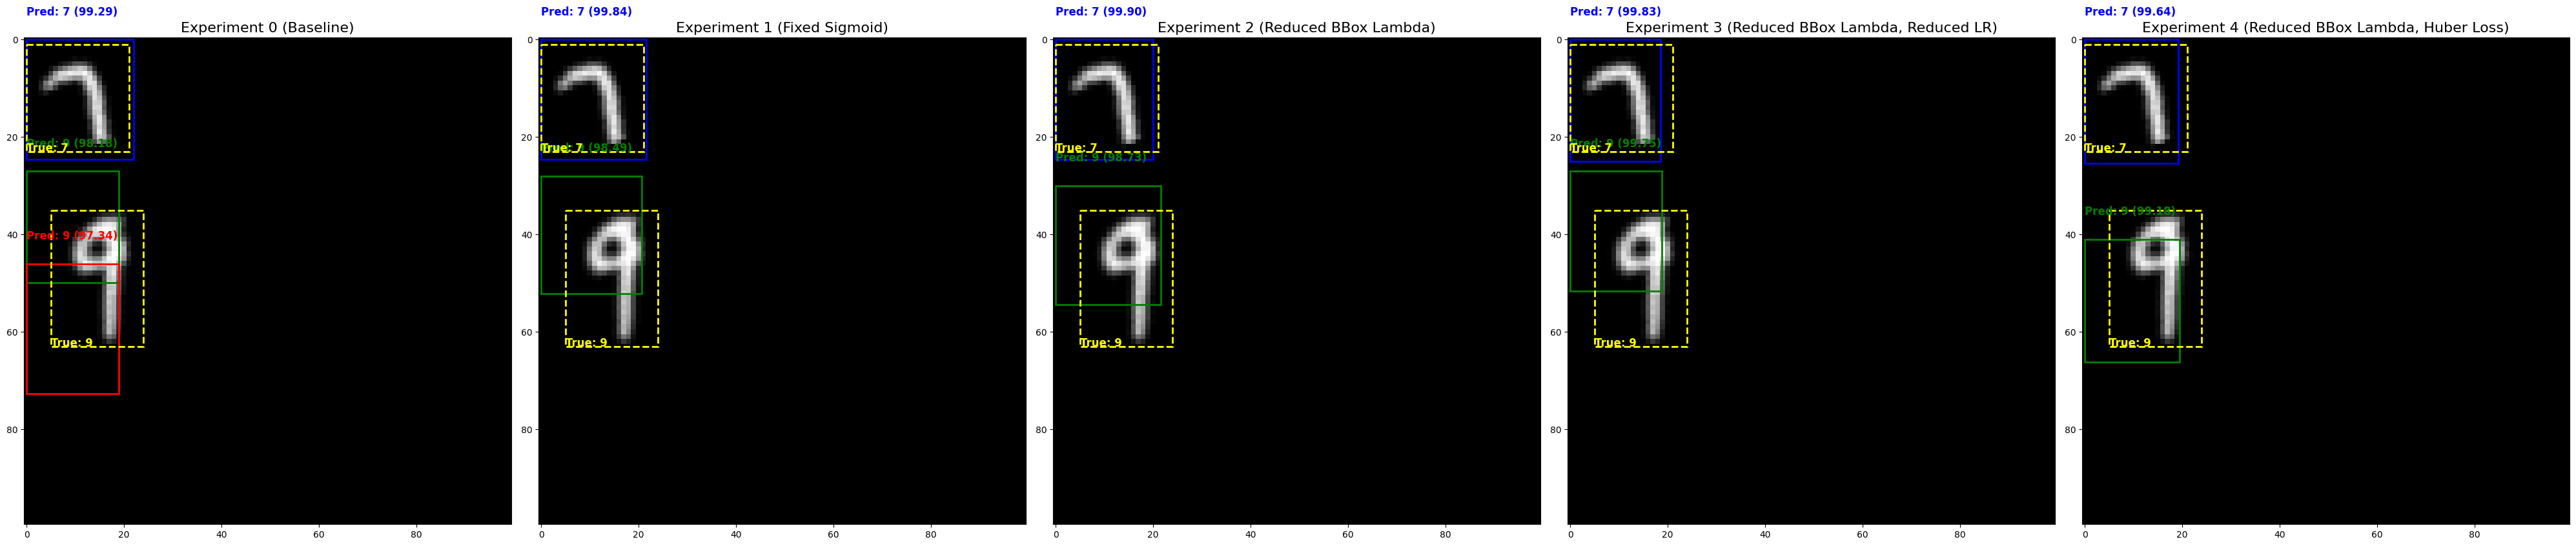

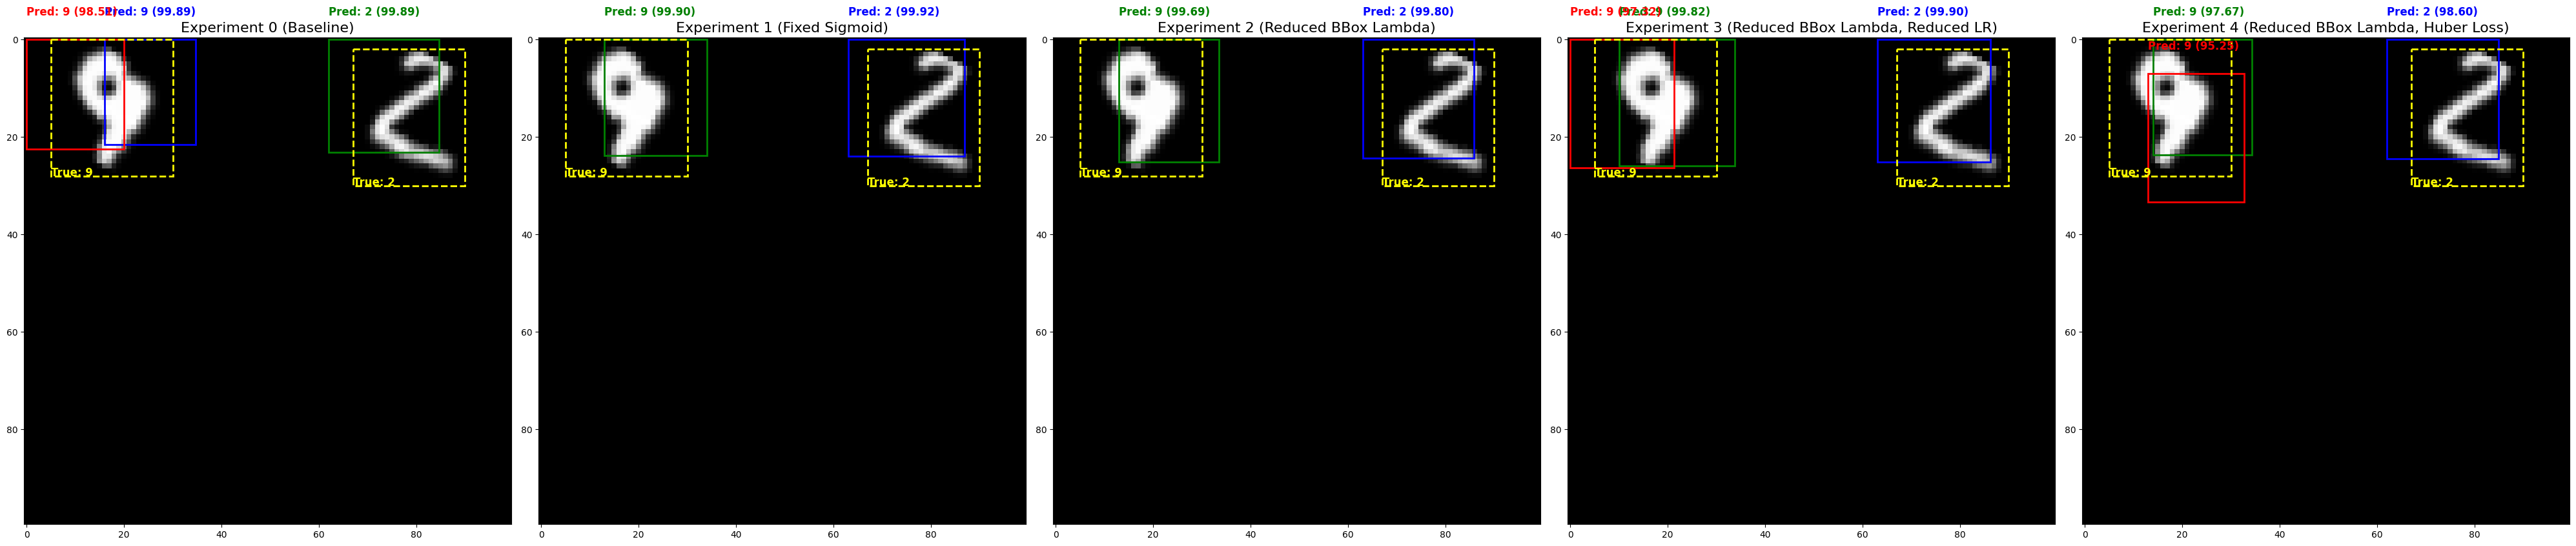

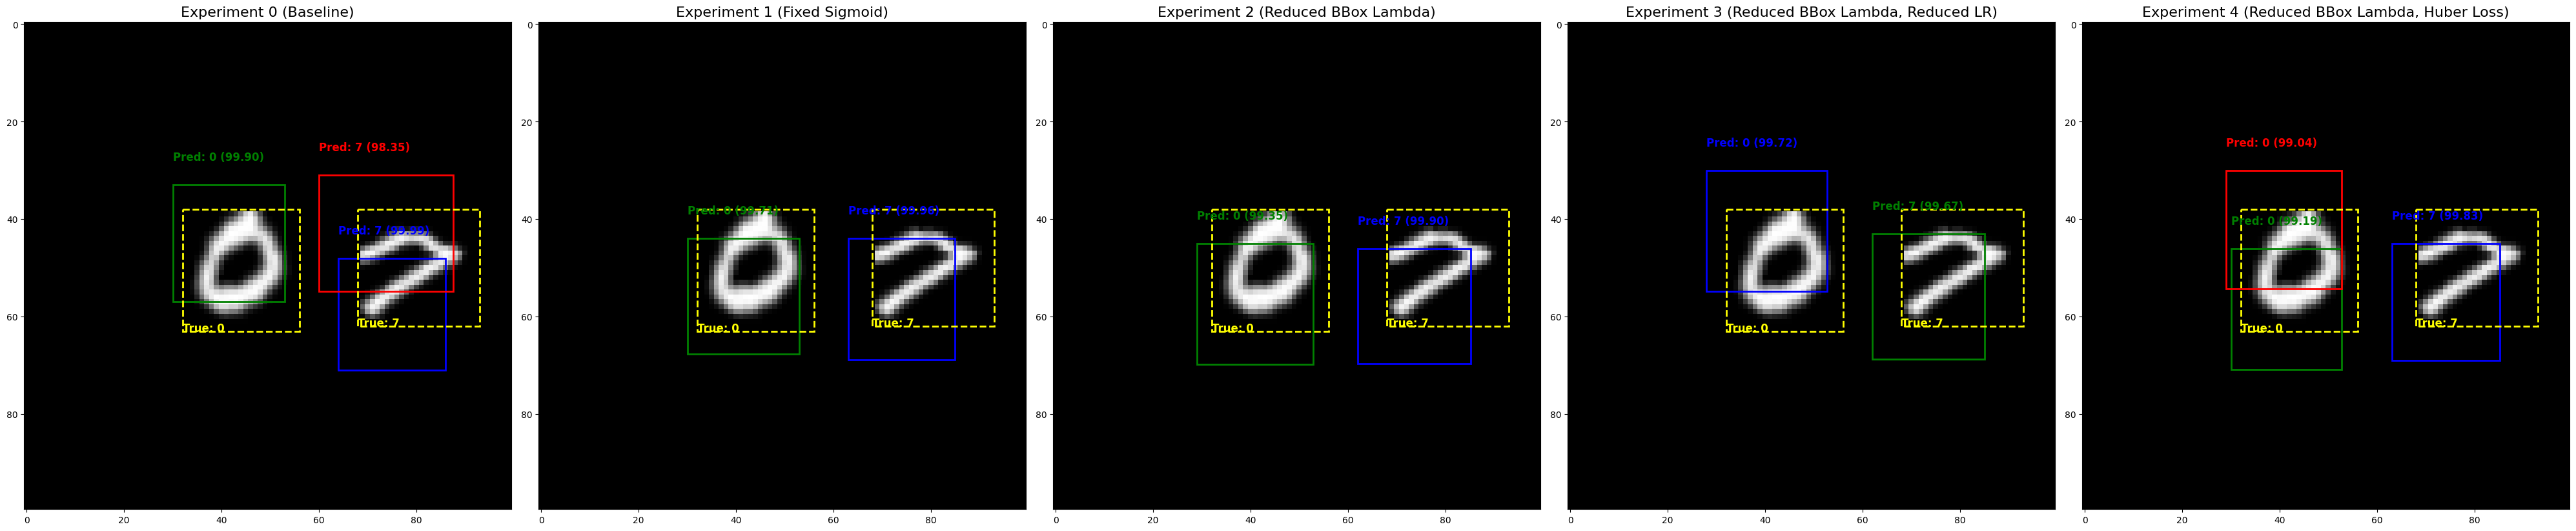

In [75]:
# --- 6. Plot the Comparison! ---
# Plot the first image (index 0) from the batch
num_random_samples = 3
for ctr in range(num_random_samples):
    image_index = np.random.randint(0,32)
    visualize_comparison(
        canvas_batch,
        true_labels_batch,
        experiment_list,
        image_index=image_index
    )